In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/RL Folder"

gaussian_filtered_images  train.csv


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Correct path — it should point to the folder containing subfolders 0, 1, 2, 3, 4
img_dir = "/content/drive/MyDrive/RL Folder/gaussian_filtered_images/gaussian_filtered_images"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Class names should now be: ['0', '1', '2', '3', '4']
print("Class names:", dataset.classes)

# Create and print the label map
label_map = {v: k for k, v in dataset.class_to_idx.items()}
print("Label map:", label_map)

# Preview a batch
images, labels = next(iter(dataloader))
print(images.shape, labels)

Class names: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Label map: {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3: 'Proliferate_DR', 4: 'Severe'}
torch.Size([32, 3, 224, 224]) tensor([2, 1, 3, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 2])


In [ ]:
from rll_env import DiabeticRetinopathyEnv

In [ ]:
env = DiabeticRetinopathyEnv(
    data_path="/content/drive/MyDrive/RL Folder",  # Just up to the folder containing the 'gaussian_filtered_images'
    batch_size=32,
    memory_limit_gb=4
)

obs, _ = env.reset()  # Discarding the 'info' dict for now
print("Initial observation shape:", obs.shape)

Initial observation shape: (3, 224, 224)


In [ ]:
!pip install stable-baselines3

In [ ]:
from stable_baselines3.common.env_util import make_vec_env

# Wrap your environment so PPO can train on it
vec_env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch

# ✅ Custom CNN Feature Extractor with dynamic shape computation
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super().__init__(observation_space, features_dim)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )

        # ✅ Dynamically compute flatten size for input shape
        with torch.no_grad():
            sample = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.linear(self.cnn(x))

# ✅ Updated policy kwargs using custom extractor
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=512),
    normalize_images=False
)

# ✅ Wrap environment
dummy_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(dummy_env, norm_obs=False, norm_reward=True, clip_reward=10.0)
vec_env = VecMonitor(vec_env)

# ✅ Evaluation callback
eval_callback = EvalCallback(
    vec_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=2048,
    deterministic=True,
    render=False
)

# ✅ Define PPO model with improved value function learning
model = PPO(
    'CnnPolicy',
    vec_env,
    verbose=1,
    learning_rate=5e-5,
    n_steps=512,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
    ent_coef=0.02,
    vf_coef=1.0,  # ✅ Stronger focus on value function
    normalize_advantage=True,
    policy_kwargs=policy_kwargs,
    tensorboard_log="./ppo_dr_tensorboard/"
)

# ✅ Train model
model.learn(total_timesteps=100_000, callback=eval_callback)

Using cuda device
Logging to ./ppo_dr_tensorboard/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -3.78    |
| time/              |          |
|    fps             | 9        |
|    iterations      | 1        |
|    time_elapsed    | 53       |
|    total_timesteps | 512      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | -3.28         |
| time/                   |               |
|    fps                  | 10            |
|    iterations           | 2             |
|    time_elapsed         | 100           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00069639646 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.6

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

ppo_model = model  # Your trained PPO model

ppo_preds = []
true_labels = []

# Get dataset directly from the env
dataset = env.dataset  # This is the torchvision.datasets.ImageFolder

for img_tensor, label in tqdm(dataset):
    # Prepare image as a batch
    obs = img_tensor.unsqueeze(0).numpy()

    # Get action prediction
    action, _ = ppo_model.predict(obs, deterministic=True)

    ppo_preds.append(action[0])       # action is returned as array
    true_labels.append(label)         # label from dataset

100%|██████████| 3662/3662 [00:32<00:00, 112.77it/s]


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report for PPO Model:\n")
print(classification_report(true_labels, ppo_preds, target_names=env.dataset.classes))

Classification Report for PPO Model:

                precision    recall  f1-score   support

          Mild       1.00      0.01      0.01       370
      Moderate       0.31      0.06      0.10       999
         No_DR       0.50      0.89      0.64      1805
Proliferate_DR       0.07      0.05      0.06       295
        Severe       0.00      0.00      0.00       193

      accuracy                           0.46      3662
     macro avg       0.38      0.20      0.16      3662
  weighted avg       0.44      0.46      0.35      3662



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


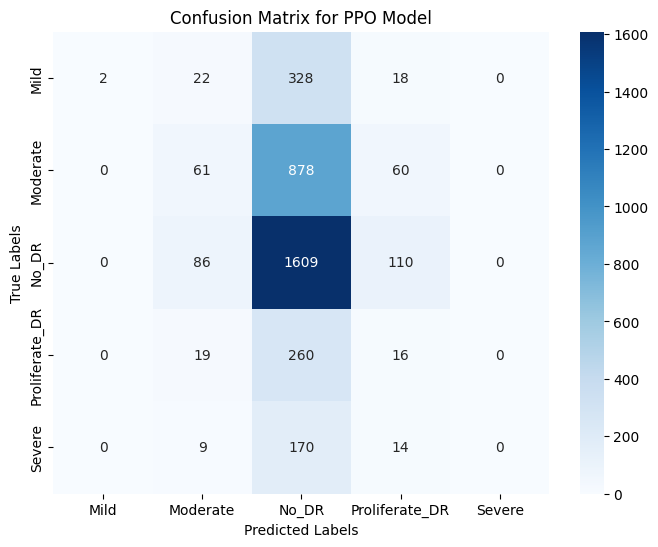

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, ppo_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=env.dataset.classes,
            yticklabels=env.dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PPO Model')
plt.show()

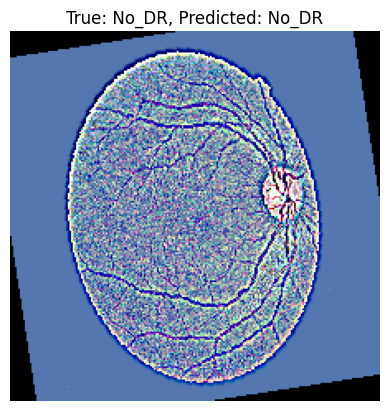

In [ ]:
import random

# Show 5 random predictions
indices = random.sample(range(len(dataset)), 1)

for i in indices:
    img, label = dataset[i]
    pred = ppo_preds[i]

    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # CHW to HWC
    plt.title(f"True: {env.dataset.classes[label]}, Predicted: {env.dataset.classes[pred]}")
    plt.axis('off')
    plt.show()